# Import libraries

In [1]:
import numpy as np
import pandas as pd
import json
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load data

In [3]:
!pip install -U -q PyDrive

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
link = "https://drive.google.com/file/d/13Fr_r60r1dqDaHdZB5XB1k6diEyIWfP3/view?usp=sharing"
 
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('clean_data.csv') 
 
data = pd.read_csv('clean_data.csv')

In [6]:
data = data.drop("Unnamed: 0", axis=1)

# Genres and Keywords extraction

In [7]:
data1 = data.copy()

In [8]:
## for keywords and genres columns
def keyword_extraction(text) :
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.replace("id", "")
    text = text.replace("name", "")
    text = nltk.word_tokenize(text)
    text = " ".join(text)
    
    return text

In [9]:
keyword_extraction(data["genres"][805])

'science fiction action drama thriller'

In [10]:
keyword_extraction(data["keywords"][805])

'subway lava volcano volcanologist los angeles'

In [11]:
## creating new columns for genres and keywords
data1["genres_data"] = data1["genres"].apply(keyword_extraction)
data1["keywords_data"] = data1["keywords"].apply(keyword_extraction)

In [12]:
## dropping genres and keywords column
data1 = data1.drop(["keywords", "genres"], axis=1)

## Word cloud of genres 

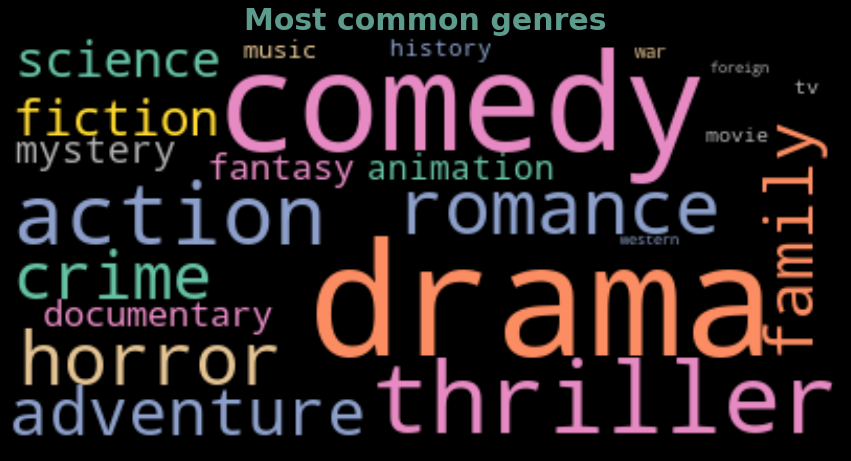

In [13]:
words_genre = " ".join(genre for genre in data1.genres_data)
plt.figure(figsize=(15,10), facecolor="black")
word_cloud_genre = WordCloud(collocations = False, background_color = 'black', colormap='Set2').generate(words_genre)
plt.imshow(word_cloud_genre, interpolation='bilinear')
plt.axis("off")
plt.title("Most common genres", fontdict={"color" : "#5d9c8d", "size" : 30}, fontweight='bold')
plt.show()

## Word cloud of keywords

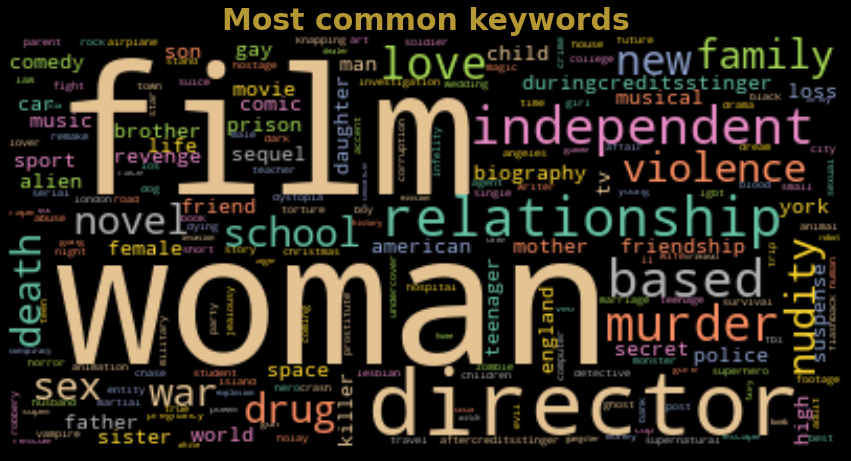

In [14]:
words_keywords = " ".join(keywords for keywords in data1.keywords_data)
plt.figure(figsize=(15,10), facecolor="black")
word_cloud_keywords = WordCloud(collocations = False, background_color = 'black', colormap='Set2').generate(words_keywords)
plt.imshow(word_cloud_keywords, interpolation='bilinear')
plt.axis("off")
plt.title("Most common keywords", fontdict={"color" : "#b59733", "size" : 30}, fontweight='bold')
plt.show()

## Cast and Crew Extraction

In [124]:
data2 = data1.copy()

In [125]:
def crew_members(text) :
    cast = []
    texts = text.split("},")[:]
    for i in range(len(texts)) :
      try :
        cast.append((texts[i].split("name': '")[1].split("'")[0].replace(" ","")).lower())
      except :
        pass
    cast = " ".join(cast)
    return cast

In [126]:
data2["cast_data"] = ""

In [127]:
## creating new cast column
for index, row in data2.iterrows() :
    try :
        text = row.cast
        casts = crew_members(text)
        data2["cast_data"].iloc[index] = casts
    except IndexError:
        data2["cast_data"].iloc[index] = ""

In [128]:
data2.head(1)

,id,title,cast,crew,imdb_link,release_year,genres_data,keywords_data,cast_data
0,862,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",https://www.imdb.com/title/tt0114709/,1995,animation comedy family,jealousy toy boy friendship friends rivalry bo...,tomhanks timallen donrickles jimvarney wallace...


### Cast word cloud

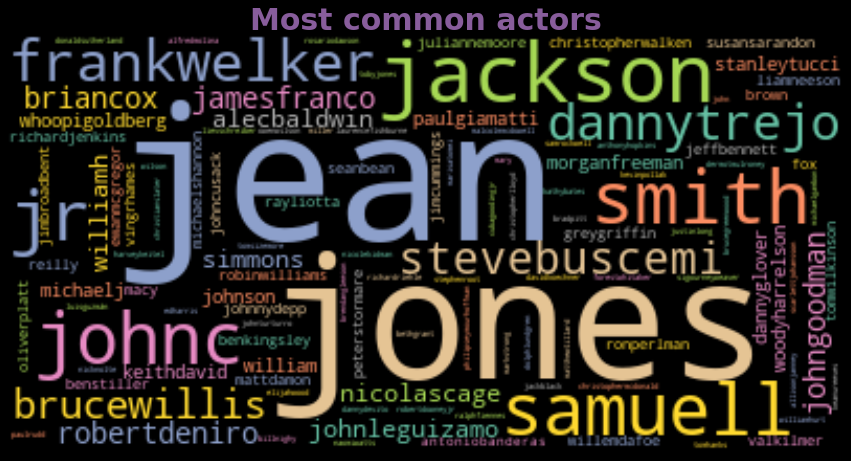

In [129]:
words_cast = " ".join(cast for cast in data2.cast_data)
plt.figure(figsize=(15,10), facecolor="black")
word_cloud_cast = WordCloud(collocations = False, background_color = 'black', colormap='Set2').generate(words_cast)
plt.imshow(word_cloud_cast, interpolation='bilinear')
plt.axis("off")
plt.title("Most common actors", fontdict={"color" : "#885d9c", "size" : 30}, fontweight='bold')
plt.show()

In [130]:
## creating crew column
data2["crew_data"] = ""
for index, row in data2.iterrows() :
    try :
        text = row.cast
        crew = crew_members(text)
        data2["crew_data"].iloc[index] = crew
    except IndexError:
        data2["crew_data"].iloc[index] = ""

### Crew word cloud

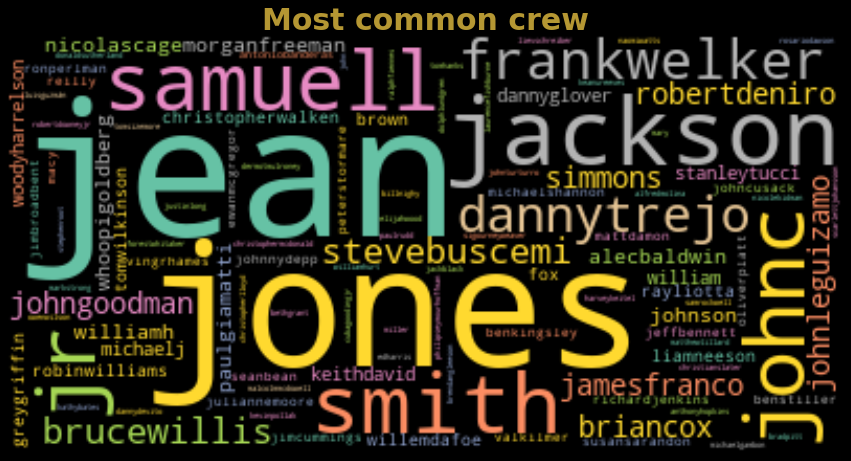

In [131]:
words_crew = " ".join(crew for crew in data2.crew_data)
plt.figure(figsize=(15,10), facecolor="black")
word_cloud_crew = WordCloud(collocations = False, background_color = 'black', colormap='Set2').generate(words_crew)
plt.imshow(word_cloud_crew, interpolation='bilinear')
plt.axis("off")
plt.title("Most common crew", fontdict={"color" : "#b59733", "size" : 30}, fontweight='bold')
plt.show()

In [132]:
## dropping cast and crew columns
data2 = data2.drop(["cast", "crew"], axis=1)

In [133]:
## lowercase the movie names
# data2["title"] = data2["title"].apply(lambda x: x.lower())

## Data cleaning

In [134]:
data3 = data2.copy()

In [135]:
data3 = data3.reset_index(drop=True)

In [136]:
data3.shape

(12961, 8)

In [137]:
data3.isna().sum()

id               0
title            0
imdb_link        0
release_year     0
genres_data      0
keywords_data    0
cast_data        0
crew_data        0
dtype: int64

In [138]:
data3["no_genres"] = data3["genres_data"].apply(lambda x: len(x.split()))
data3["no_keywords"] = data3["keywords_data"].apply(lambda x: len(x.split()))
data3["no_cast"] = data3["cast_data"].apply(lambda x: len(x.split()))
data3["no_crew"] = data3["crew_data"].apply(lambda x: len(x.split()))

In [139]:
data3[data3["id"]==10195]

,id,title,imdb_link,release_year,genres_data,keywords_data,cast_data,crew_data,no_genres,no_keywords,no_cast,no_crew
6120,10195,Thor,https://www.imdb.com/title/tt0800369/,2011,adventure fantasy action,new mexico banishment shield marvel comic hamm...,chrishemsworth natalieportman tomhiddleston an...,chrishemsworth natalieportman tomhiddleston an...,3,22,31,31


In [140]:
## drop rows with no cast and crew
data3 = data3[(data3["no_crew"]!=0) & (data3["no_cast"]!=0)]

In [142]:
## drop rows with no genre information
data3 = data3[data3["no_genres"]!=0]

In [143]:
## reset index
data3 = data3.reset_index(drop=True)

# Applying Stemming on keywords data

In [144]:
ps = PorterStemmer()
def stemming(text) :
  text = text.split(" ")
  text = [ps.stem(word) for word in text if word not in stopwords.words("english")]
  text = " ".join(text)
  return text

In [145]:
for index, row in data3.iterrows() :
  text = row["keywords_data"]
  preprocessed_text = stemming(text)
  row["keywords_data"] = preprocessed_text

In [146]:
data3.head(2)

,id,title,imdb_link,release_year,genres_data,keywords_data,cast_data,crew_data,no_genres,no_keywords,no_cast,no_crew
0,862,Toy Story,https://www.imdb.com/title/tt0114709/,1995,animation comedy family,jealousy toy boy friendship friends rivalry bo...,tomhanks timallen donrickles jimvarney wallace...,tomhanks timallen donrickles jimvarney wallace...,3,15,13,13
1,8844,Jumanji,https://www.imdb.com/title/tt0113497/,1995,adventure fantasy family,board game disappearance based on children s b...,robinwilliams jonathanhyde kirstendunst bradle...,robinwilliams jonathanhyde kirstendunst bradle...,3,13,26,26


In [147]:
data3["keywords_data"].apply(lambda x: len(x.split())).max()

191

In [148]:
data3["keywords_data"][1056]

'italy postman mafia escape gangster emigrant'

In [149]:
## dropping some columns
data3 = data3.drop(["no_genres", "no_keywords", "no_cast", "no_crew"], axis=1)

# Saving dataframe for next step

In [152]:
data3 = data3.reset_index(drop=True)

In [41]:
data3[data3["id"]==10195]

,id,title,imdb_link,release_year,genres_data,keywords_data,cast_data,crew_data


In [154]:
data3.to_csv("text_preprocessed_data.csv")